In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import arff
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bitcoin_db_path = '../BitcoinHeist_Ransomware/dataset.arff'
bitcoin_data = arff.load(open(bitcoin_db_path,'r'))

bitcoin_columns = [c[0] for c in bitcoin_data['attributes']]
bitcoin_columns

bitcoin_df = pd.DataFrame(bitcoin_data['data'], columns=bitcoin_columns)
bitcoin_df.shape

# y_labels = bitcoin_df['label'] == 'white'
# bitcoin_df['y'] = y_labels.astype('int')

bitcoin_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000,princetonLocky


In [3]:
## making duplicate row if dataset only has 1 row for given class
label_grp_df = bitcoin_df.groupby('label')
min_label_size = 2
test_size = 0.2
small_sized_labels = []
small_sized_labels_df = pd.DataFrame(columns=bitcoin_df.columns)
# y_df = pd.get_dummies(bitcoin_df.iloc[:,-1])
train_df = pd.DataFrame(columns=bitcoin_df.columns)
test_df = pd.DataFrame(columns=bitcoin_df.columns)

for grp_label, grp in label_grp_df:
    grp_size = len(grp)
    print(grp_label, grp_size)
    if grp_size < min_label_size:
        small_sized_labels.append(grp_label)
        #print(f'grp:{grp}')
        for row in grp.iterrows():
            #print('row',row[1])
            small_sized_labels_df = small_sized_labels_df.append(row[1], ignore_index=True)
            train_df = train_df.append(row[1], ignore_index=True)
            test_df = test_df.append(row[1], ignore_index=True)
    else:
        temp_train, temp_test = train_test_split(grp, test_size=0.2)
        print(f'\t temp_train size:{temp_train.shape}, temp_test size:{temp_test.shape}')
        train_df = pd.concat([train_df, temp_train], ignore_index=True)
        test_df = pd.concat([test_df, temp_test], ignore_index=True)
        
print(f'\nsmall sized labels:{small_sized_labels}')
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
small_sized_labels_df

montrealAPT 11
	 temp_train size:(8, 10), temp_test size:(3, 10)
montrealComradeCircle 1
montrealCryptConsole 7
	 temp_train size:(5, 10), temp_test size:(2, 10)
montrealCryptXXX 2419
	 temp_train size:(1935, 10), temp_test size:(484, 10)
montrealCryptoLocker 9315
	 temp_train size:(7452, 10), temp_test size:(1863, 10)
montrealCryptoTorLocker2015 55
	 temp_train size:(44, 10), temp_test size:(11, 10)
montrealDMALocker 251
	 temp_train size:(200, 10), temp_test size:(51, 10)
montrealDMALockerv3 354
	 temp_train size:(283, 10), temp_test size:(71, 10)
montrealEDA2 6
	 temp_train size:(4, 10), temp_test size:(2, 10)
montrealFlyper 9
	 temp_train size:(7, 10), temp_test size:(2, 10)
montrealGlobe 32
	 temp_train size:(25, 10), temp_test size:(7, 10)
montrealGlobeImposter 55
	 temp_train size:(44, 10), temp_test size:(11, 10)
montrealGlobev3 34
	 temp_train size:(27, 10), temp_test size:(7, 10)
montrealJigSaw 4
	 temp_train size:(3, 10), temp_test size:(1, 10)
montrealNoobCrypt 483
	 temp_t

,address,year,day,length,weight,count,looped,neighbors,income,label
0,1HssDyDTZj1hVdwhdpF49wLKLPQoCRJB9T,2016,292,144,0.051214,1241,0,2,203320001,montrealComradeCircle
1,1Ha4Y7QegJL2t577XK6nSUdCYAKKQC99sG,2016,271,6,0.062500,1,1,3,2900000000,montrealSam
2,1EEHF6uucK2UNtbwxTyAzZ74wNudApYWQm,2017,144,144,0.412207,4511,0,1,100000000,montrealXLocker


In [4]:
X_train = train_df.iloc[:, 1:9]
y_train = pd.get_dummies(train_df.iloc[:,-1])
X_test = test_df.iloc[:, 1:9]
y_test = pd.get_dummies(test_df.iloc[:,-1])

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
train_df[train_df['label']!='white'].count()

address      33122
year         33122
day          33122
length       33122
weight       33122
count        33122
looped       33122
neighbors    33122
income       33122
label        33122
dtype: int64

In [7]:
y_test.values.shape, X_train.shape, y_train.shape

((583351, 29), (2333349, 8), (2333349, 29))

In [8]:
# %%time
# clf = TabNetClassifier()  #TabNetRegressor()
# # clf.fit(
# #   X_train, y_train,
# #   eval_set=[(X_valid, y_valid)]
# # )
# clf.fit(
#   X_train, y_train
# )

In [9]:
%%time
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
clf = TabNetMultiTaskClassifier()
clf.fit(
  X_train, y_train.values, max_epochs=10, 
    eval_set=[(X_test, y_test.values)]
)
# preds = clf.predict(X_test)

Device used : cuda
epoch 0  | loss: 0.00797 | val_0_logloss: 0.00475 |  0:02:53s
epoch 1  | loss: 0.00474 | val_0_logloss: 0.00469 |  0:05:46s
epoch 2  | loss: 0.00465 | val_0_logloss: 0.00472 |  0:08:39s
epoch 3  | loss: 0.00465 | val_0_logloss: 0.00457 |  0:11:31s
epoch 4  | loss: 0.00453 | val_0_logloss: 0.00457 |  0:14:22s
epoch 5  | loss: 0.00452 | val_0_logloss: 0.00456 |  0:17:13s
epoch 6  | loss: 0.0045  | val_0_logloss: 0.00466 |  0:20:05s
epoch 7  | loss: 0.00459 | val_0_logloss: 0.0046  |  0:22:56s
epoch 8  | loss: 0.00458 | val_0_logloss: 0.00469 |  0:25:45s
epoch 9  | loss: 0.00456 | val_0_logloss: 0.00461 |  0:28:38s
Stop training because you reached max_epochs = 10 with best_epoch = 5 and best_val_0_logloss = 0.00456
Best weights from best epoch are automatically used!
Wall time: 31min 39s


In [10]:
%%time
train_preds = np.array(clf.predict(X_train)).T.astype('int')
accuracy_score(y_train.values, train_preds)

Wall time: 1min 54s


0.9858049524524621

In [11]:
%%time
test_preds = np.array(clf.predict(X_test)).T.astype('int')
accuracy_score(y_test.values, test_preds)

Wall time: 28.4 s


0.985782144883612

In [12]:
y_train_linear = [row.argmax() for row in y_train.values]
y_test_linear = [row.argmax() for row in y_test.values]

y_test_pred_linear = [row.argmax() for row in test_preds]
y_train_pred_linear = [row.argmax() for row in train_preds]
# y_test_pred_linear 

In [13]:
train_cnf_matrix = confusion_matrix(y_train_linear, y_train_pred_linear)
test_conf_matrix = confusion_matrix(y_test_linear, y_test_pred_linear)

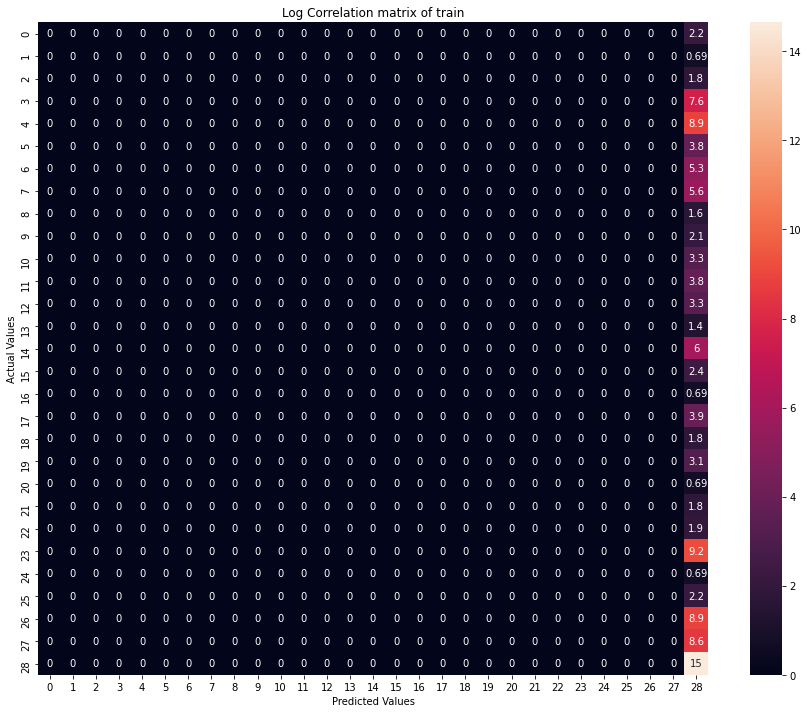

In [16]:
plt.figure(figsize=(15,12))
train_cnf_df = pd.DataFrame(train_cnf_matrix, index= range(29), columns=range(29))
sns.heatmap(np.log(train_cnf_df+1), annot=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title("Log Correlation matrix of train")
plt.savefig('tab_net_conf_mat_train.png')

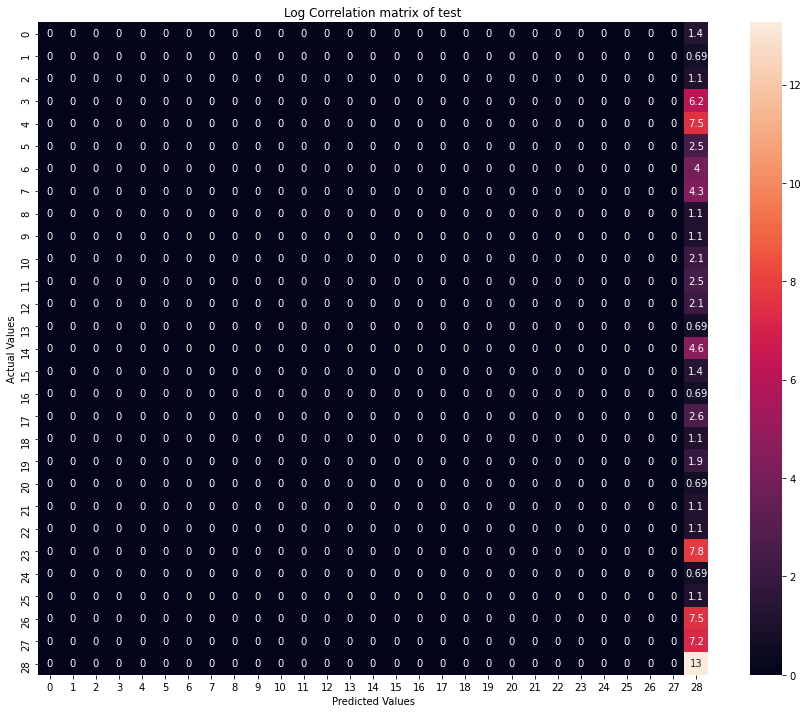

In [17]:
plt.figure(figsize=(15,12))
test_cnf_df = pd.DataFrame(test_conf_matrix, index= range(29), columns=range(29))
sns.heatmap(np.log(test_cnf_df+1), annot=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title("Log Correlation matrix of test")
plt.savefig('tab_net_conf_mat_test.png')